# Pyradiomics GLCM
### (recomended python <= 3.9 )

"""
!@gpinedaortiz
 IDiA Lab
"""

In [1]:
pip install -r pyrad_requeriments.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Could not fetch URL https://pypi.ngc.nvidia.com/simpleitk/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='developer.download.nvidia.com', port=443): Max retries exceeded with url: /compute/redist/simpleitk/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)'))) - skipping
Could not fetch URL https://pypi.ngc.nvidia.com/pyradiomics/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='developer.download.nvidia.com', port=443): Max retries exceeded with url: /compute/redist/pyradiomics/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)'))) - skipping
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 135.0 MB/s eta 0:00:0

In [4]:
import os
import six
import json
import logging
import glob
import numpy as np
import SimpleITK as sitk
import pandas as pd
import nibabel as nib
from radiomics import featureextractor
from matplotlib.gridspec import GridSpec
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm
from pyrad_utils import *

In [5]:
FORMAT = '%(asctime)-15s %(levelname)s %(funcName)s  %(message)s'
logging.basicConfig(format=FORMAT, level=logging.DEBUG)
# root_path = 'Y:/Groups/IDIAGroup/Data/_Brain/Radiology/_Adult/_Glioma/' # running at local level: change the volume /disk accordingly

In [6]:
with open('pyradiomics_setup.json', 'r') as f:
    data_params = json.load(f)

# Update Params file

In [7]:
# update params : folder estructure
data_params['mri_mod']="T2"
data_params['mri_data']="site2"
data_params['subdir_data']="subdir1"
data_params['pipeline']="pp2"
data_params['mask_str']="mask2"
data_params['tp']="tp1"
# Habitat/tumor region -- label value in mask
data_params['habitat']="RoI1"
data_params['label_val']=2
# feature familiy
data_params['feature']="feat1"
data_params['feat_folder']="folder_glcm"
data_params['plot_feature_map']=True
# batch processing parameters
data_params['id1']=61
data_params['batch_size']=1
data_params['batch']='03'
data_params['port']='dgx002_73'
data_params['root_path']='/app/Data/_Brain/Radiology/_Adult/_Glioma/'
data_params['output_features']='Feature_extraction/Radiomics_features'
data_params['output_fmatrix']='Feature_extraction/Feature_matrix'
data_params

{'mri_mod': 'T2',
 'mri_sites': {'site1': 'UCSF-PDGM',
  'site2': 'LUMIERE',
  'site3': 'CCF',
  'site4': 'IVYGAP',
  'site5': 'xCures'},
 'mri_data': 'site2',
 'subdirs': {'subdir1': 'Preprocessed',
  'subdir2': 'Preprocessed/Pre-op-Post-op'},
 'subdir_data': 'subdir1',
 'pipelines': {'pp1': 'bias_IntStnd2',
  'pp2': 'SRI24_BiasCorrect_IntStnd',
  'pp3': 'SRI24_SkullS_BiasCorrect_IntStnd'},
 'pipeline': 'pp2',
 'masks': {'mask1': 'tumor_segmentation',
  'mask2': 'tumor_segmentation_brats_SRI24',
  'mask3': 'SRI24_brats',
  'mask4': 'brats_SRI24',
  'mask5': 'brats_SRI24'},
 'mask_str': 'mask2',
 'brain_mask_str': 'brain_segmentation',
 'time_point': {'tp1': 'Baseline', 'tp2': 'time01'},
 'tp': 'tp1',
 'habitats': {'RoI1': 'Edema', 'RoI2': 'Enhancing', 'RoI3': 'All_tumor'},
 'habitat': 'RoI1',
 'feature_family': {'feat1': 'glcm',
  'feat2': 'Collage',
  'feat3': 'shape',
  'feat4': 'Texture',
  'feat5': 'TextureShape',
  'feat6': 'GLiODIL_topology',
  'feat7': 'glcmShapeBioM',
  'feat8

In [8]:
# Feature Extractor Level
levels = pow(2, 13)
#binWidth_ranges=list([2048,1024,512,256,128])
binWidth_ranges=list([128])
#kernel_radius=list([1,2,3])
kernel_radius=list([3])
distances = [1]
init_value = 0 
voxel_batch = 600
voxel_based = True
masked_kernel=False
enabled_features = {'glcm': []}

In [6]:
# # Save to a JSON file
# with open('radiomics_setup.json', 'w') as f:
#     json.dump(data_params, f, indent=4)

# Set directory

In [29]:
FileTags=FilePath_tags(**data_params)
habitat, sufx, name_a, labels, imgs , label_val = FileTags.input_tags()
batch_list= FileTags.batch_split(print_batch=True)

Segmentation with BraTS convention: necrosis NEC : 1, Edema Ed : 2, Enhancing ET : 4 , All region TM : 5 

Constructing file paths / lists
habitat: Edema, sufix: ED, feature name: Edema_glcm, label in mask: 2

Number of segmentation files: 85, number of MRI scans: 83 , for MIR modality: T2

Batch size: 1
/app/Data/_Brain/Radiology/_Adult/_Glioma/LUMIERE/Preprocessed/Patient-060/Baseline/Patient-060_01_tumor_segmentation_brats_SRI24.nii.gz


# single CPU processing


Patient ID: .. Patient-060, time point:Baseline
MRI scan: .. /app/Data/_Brain/Radiology/_Adult/_Glioma/LUMIERE/Preprocessed/Patient-060/Baseline/Patient-060_T2_SRI24_BiasCorrect_IntStnd.nii.gz


2024-11-19 17:53:44,607 INFO __init__  No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
2024-11-19 17:53:44,608 INFO __init__  Enabled image types: {'Original': {}}
2024-11-19 17:53:44,608 INFO __init__  Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
2024-11-19 17:53:44,609 INFO __init__  Applying custom setting overrides: {'normalize': False, 'binWidth': 512, 'resampledPixelSpacing': None, 'interpolator': None, 'verbose': False, 'additionalInfo': False, 'label': 2, 'distances': [1], 'voxelBased': True, 'kernelRadius': 3, 'maskedKernel': False, 'initValue': 0, 'voxelBatch': 600, 'glcm': {'force2D': 


Calculating Haralick for tumor habitat: Edema_glcm, binWidth:512,  window size 3
Calculating GLCM for image:        /app/Data/_Brain/Radiology/_Adult/_Glioma/LUMIERE/Preprocessed/Patient-060/Baseline/Patient-060_T2_SRI24_BiasCorrect_IntStnd.nii.gz
Calculating GLCM for segmentation: /app/Data/_Brain/Radiology/_Adult/_Glioma/LUMIERE/Preprocessed/Patient-060/Baseline/Patient-060_01_tumor_segmentation_brats_SRI24.nii.gz
saving a temporary npy to avoid batch overlapping


2024-11-19 17:53:44,810 INFO execute  Adding image type "Original" with custom settings: {}
2024-11-19 17:53:44,810 INFO execute  Calculating features for original image
2024-11-19 17:53:44,819 INFO computeFeatures  Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2024-11-19 17:53:45,545 WARNING getSumAverageFeatureValue  GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2024-11-19 17:53:46,162 WARNING getSumAverageFeatureValue  GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
2024-11-19 17:53:46,739 WARNING getSumAverageFeatureValue  GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefo

GLCM Stats name: original_glcm_Autocorrelation
GLCM Stats name: original_glcm_ClusterProminence
GLCM Stats name: original_glcm_ClusterShade
GLCM Stats name: original_glcm_ClusterTendency
GLCM Stats name: original_glcm_Contrast
GLCM Stats name: original_glcm_Correlation
GLCM Stats name: original_glcm_DifferenceAverage
GLCM Stats name: original_glcm_DifferenceEntropy
GLCM Stats name: original_glcm_DifferenceVariance
GLCM Stats name: original_glcm_Id
GLCM Stats name: original_glcm_Idm
GLCM Stats name: original_glcm_Idmn
GLCM Stats name: original_glcm_Idn
GLCM Stats name: original_glcm_Imc1
GLCM Stats name: original_glcm_Imc2
GLCM Stats name: original_glcm_InverseVariance
GLCM Stats name: original_glcm_JointAverage
GLCM Stats name: original_glcm_JointEnergy
GLCM Stats name: original_glcm_JointEntropy
GLCM Stats name: original_glcm_MCC
GLCM Stats name: original_glcm_MaximumProbability
GLCM Stats name: original_glcm_SumAverage
GLCM Stats name: original_glcm_SumEntropy
GLCM Stats name: origin

2024-11-19 17:54:51,034 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb06721a0>


number of non zero voxels in mask all the habitats 66379
bounding_box coordinates (slice(78, 139, None), slice(75, 153, None), slice(119, 181, None))
cropped mask (61, 78, 62)
cropped image (61, 78, 62)
original_glcm_Autocorrelation
glcm_map shape (61, 78, 62)


2024-11-19 17:54:51,257 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6cb5fc0>


original_glcm_ClusterProminence
glcm_map shape (61, 78, 62)


2024-11-19 17:54:51,465 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb68fcd00>


original_glcm_ClusterShade
glcm_map shape (61, 78, 62)


2024-11-19 17:54:51,698 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb69bde40>


original_glcm_ClusterTendency
glcm_map shape (61, 78, 62)


2024-11-19 17:54:51,929 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb02c23b0>


original_glcm_Contrast
glcm_map shape (61, 78, 62)


2024-11-19 17:54:52,159 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabdc5ff0>


original_glcm_Correlation
glcm_map shape (61, 78, 62)
original_glcm_DifferenceAverage
glcm_map shape (61, 78, 62)


2024-11-19 17:54:52,600 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabf9ca90>
2024-11-19 17:54:52,821 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb49cdfc0>


original_glcm_DifferenceEntropy
glcm_map shape (61, 78, 62)


2024-11-19 17:54:53,053 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfab6f6410>


original_glcm_DifferenceVariance
glcm_map shape (61, 78, 62)


2024-11-19 17:54:53,276 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb0120cd0>


original_glcm_Id
glcm_map shape (61, 78, 62)


2024-11-19 17:54:53,515 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabd9de70>


original_glcm_Idm
glcm_map shape (61, 78, 62)


2024-11-19 17:54:53,752 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6b1fee0>


original_glcm_Idmn
glcm_map shape (61, 78, 62)


2024-11-19 17:54:53,987 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6aae4d0>


original_glcm_Idn
glcm_map shape (61, 78, 62)


2024-11-19 17:54:54,224 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfab618850>


original_glcm_Imc1
glcm_map shape (61, 78, 62)


2024-11-19 17:54:54,482 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb687bd00>


original_glcm_Imc2
glcm_map shape (61, 78, 62)


2024-11-19 17:54:54,720 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfab8cee60>


original_glcm_InverseVariance
glcm_map shape (61, 78, 62)


2024-11-19 17:54:54,956 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb069aad0>


original_glcm_JointAverage
glcm_map shape (61, 78, 62)


2024-11-19 17:54:55,188 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabc5c880>


original_glcm_JointEnergy
glcm_map shape (61, 78, 62)


2024-11-19 17:54:55,405 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabdb8dc0>


original_glcm_JointEntropy
glcm_map shape (61, 78, 62)


2024-11-19 17:54:55,643 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfabee1810>


original_glcm_MCC
glcm_map shape (61, 78, 62)


/app/Codebase/gustavo_script/Radiomics_Features_extraction/Radiomics_texture/pyrad_utils.py:771: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
2024-11-19 17:54:55,879 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6ad00a0>


original_glcm_MaximumProbability
glcm_map shape (61, 78, 62)


2024-11-19 17:54:56,231 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6889d80>


original_glcm_SumAverage
glcm_map shape (61, 78, 62)


2024-11-19 17:54:56,465 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfab988b80>


original_glcm_SumEntropy
glcm_map shape (61, 78, 62)


2024-11-19 17:54:56,698 DEBUG _get_ticker_locator_formatter  locator: <matplotlib.ticker.AutoLocator object at 0x7fbfb6b9d930>


original_glcm_SumSquares
glcm_map shape (61, 78, 62)
CPU usage: 7.5 %
Memory usage: 12.9 %
Total memory: 503.75 GB
Available memory: 438.94 GB
Used memory: 57.74 GB
Temp Haralick feature array saved.........................................................................................


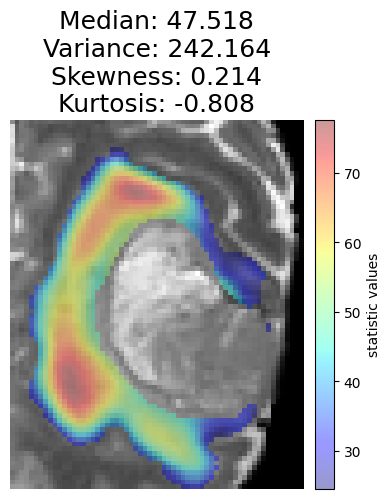

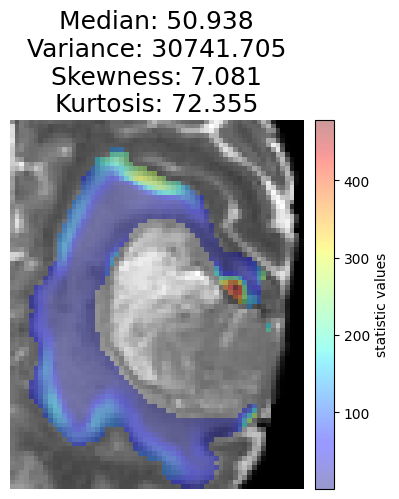

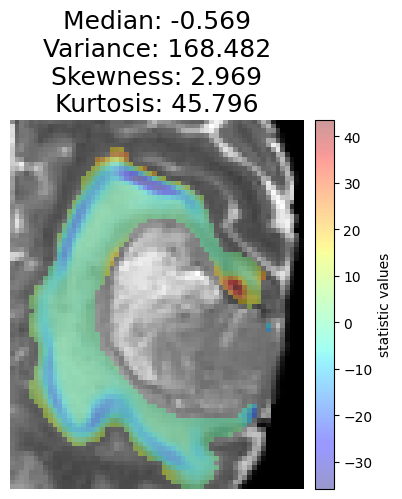

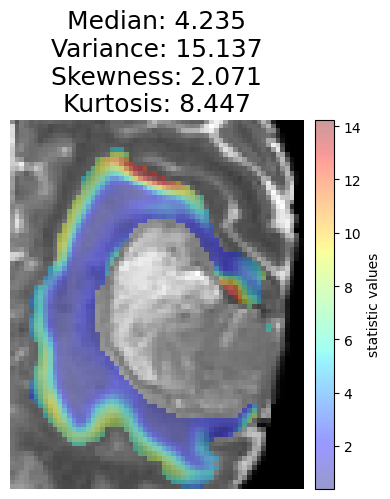

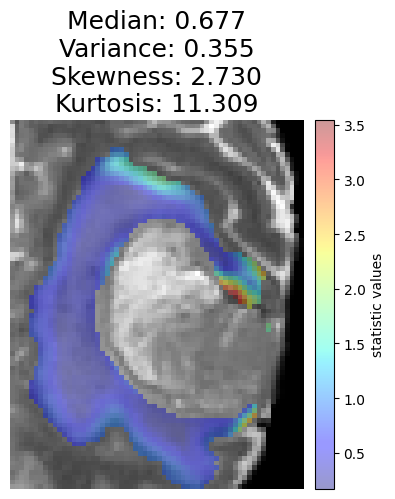

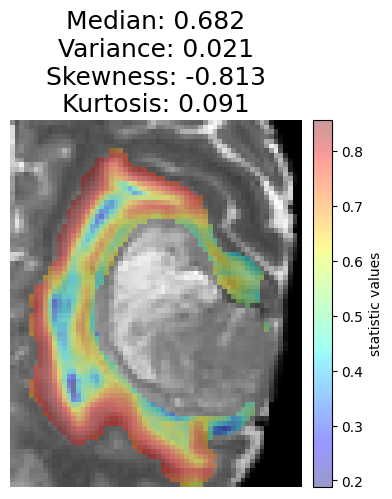

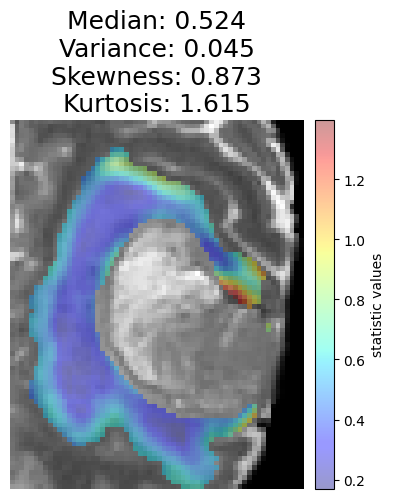

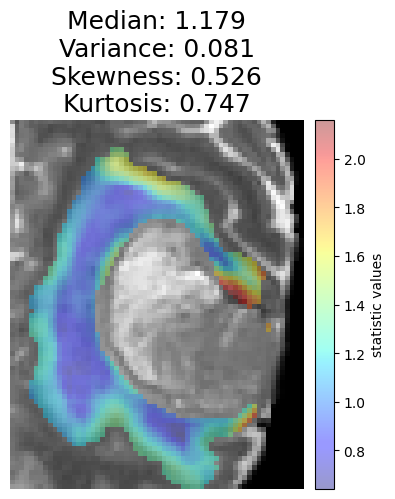

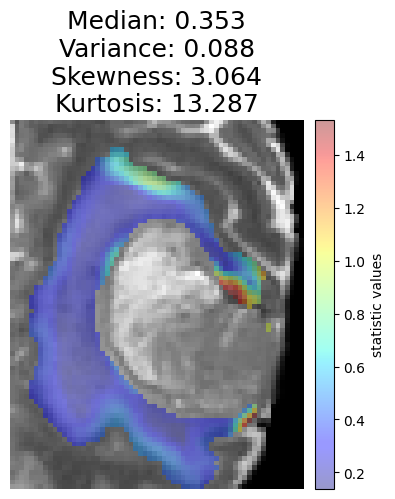

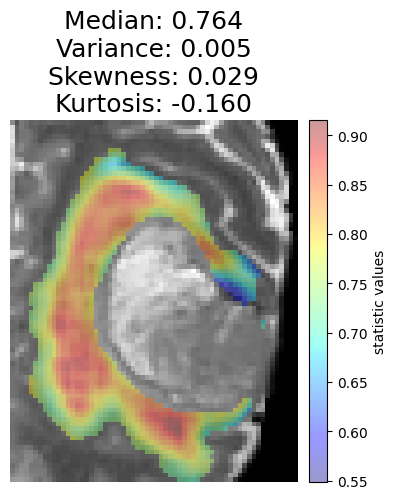

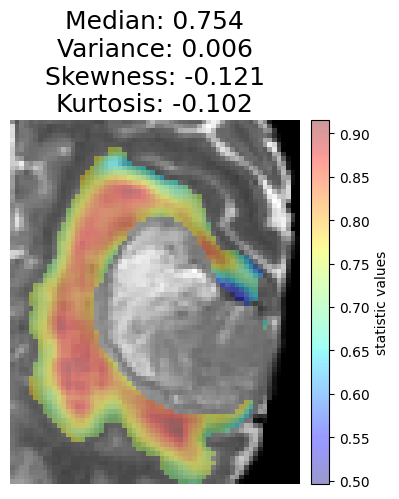

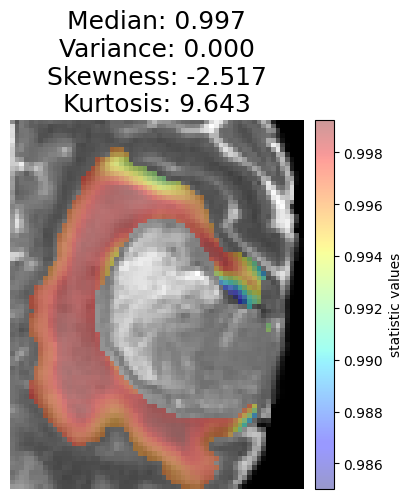

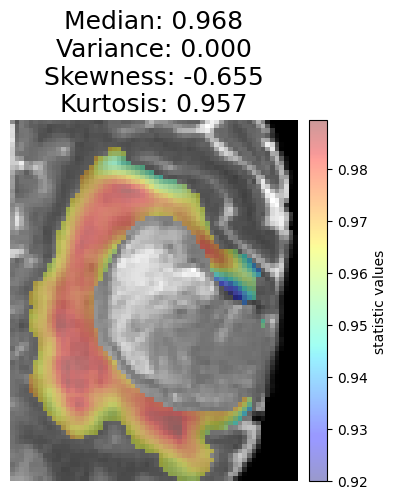

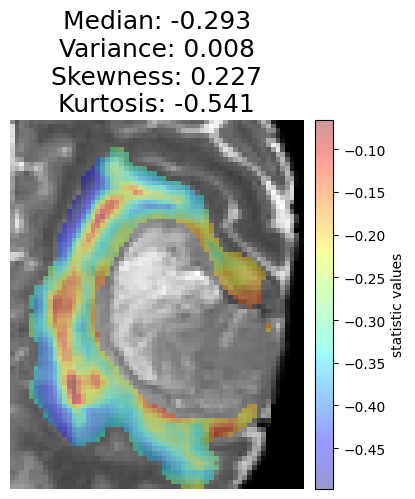

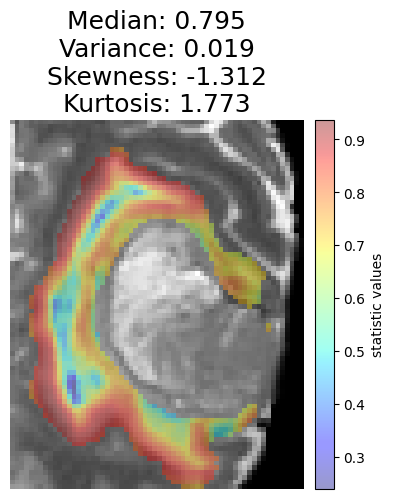

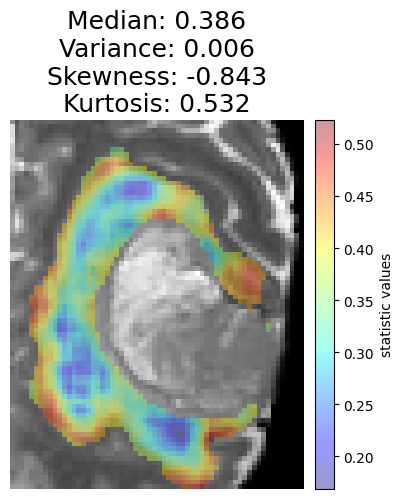

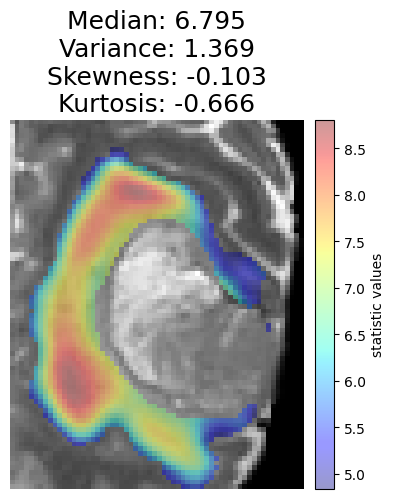

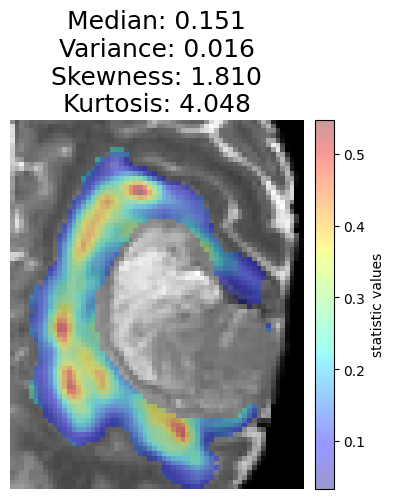

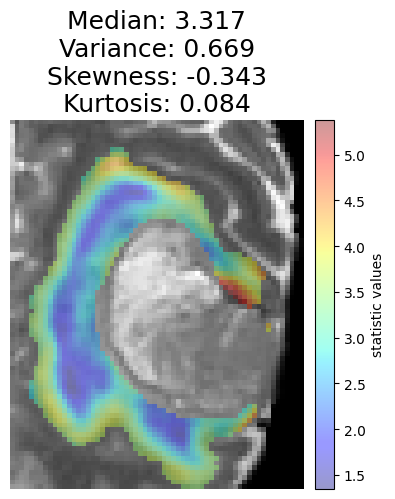

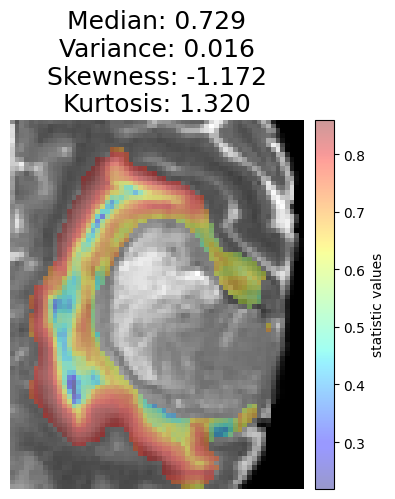

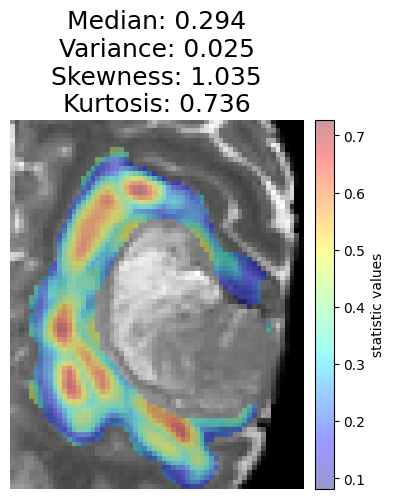

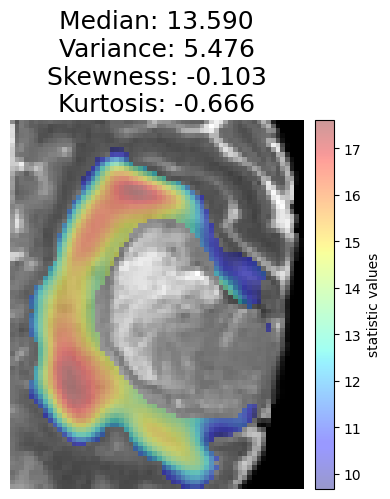

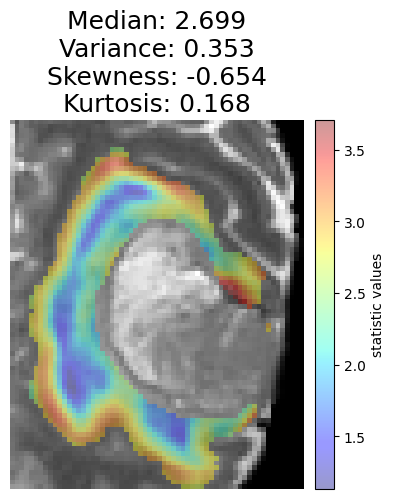

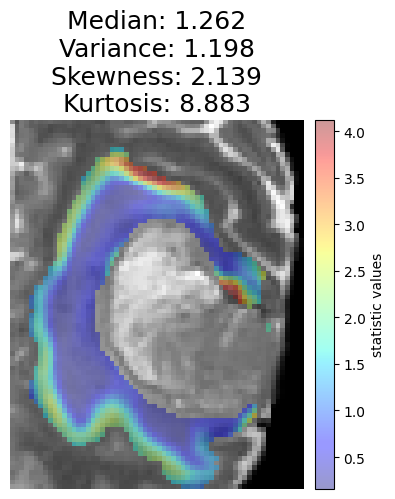

In [30]:
ids = []
ls_stats = []

for i in batch_list:
    
    id_label , mri_pos = FileTags.Pairing_Label_mri(i)
    if not mri_pos:
        continue
    
    mri_sitk = sitk.ReadImage(imgs[mri_pos[0]]) 
    mask_sitk = sitk.ReadImage(i) # to input Pyradiomic extractor
    mask_nib  = sitk.GetArrayFromImage(mask_sitk)
  
    for ws in kernel_radius:
        for binWidth in binWidth_ranges:
            
            tmp_name, tmp_name_extractor = FileTags.Output_tags(ws,binWidth,levels)
            str_log , log_file = FileTags.processing_logger()
      
            if label_val in mask_nib and not os.path.isfile(tmp_name_extractor):
                label_vol=mask_binarization(mask_nib, label_val, habitat)
                
                if label_vol[0].shape[0] > 50 :
                    print('\nCalculating Haralick for tumor habitat: {}, binWidth:{},  window size {}'.format(name_a,binWidth,ws))
                    print('Calculating GLCM for image:        {}'.format(imgs[mri_pos[0]]))
                    print('Calculating GLCM for segmentation: {}'.format(i))
                    
                    print('saving a temporary npy to avoid batch overlapping')
                    np.save(tmp_name_extractor, np.full((1, 24), np.nan))
                    params = create_pyradiomics_params(binWidth, label_val, distances, voxel_based, ws, masked_kernel, init_value, voxel_batch)
                    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
                    extractor.disableAllFeatures()
                    extractor.enableFeaturesByName(**enabled_features)
                    result = extractor.execute(mri_sitk, mask_sitk)
                    glcm_stats=compute_haralick_stats(result, print_stats_list=True)
                    ids.append(str_log)
                    if data_params['plot_feature_map']:
                        cropped_image_array, cropped_mask_array=get_cropped_images(mri_sitk,mask_sitk,**data_params)
                        plot_glcm_map(FileTags,cropped_image_array, cropped_mask_array, result, glcm_stats, **data_params)
                    glcm_stats=glcm_stats.reshape(1,glcm_stats.shape[0]*glcm_stats.shape[1])
                    
                else:
                    print('insuficient voxels for computing Haralick .........................................................................................................')
                    continue
            else:
                print('\nHaralick features already exists (npy) or not calculated. Label %d not found in mask for:' %label_val, id_label)
                ids.append(str_log)
                with open(log_file, 'w') as f:
                    for item in ids:
                        f.write("%s\n" %item)
                continue
                
            log_resources()
            np.save(tmp_name, glcm_stats)
            np.save(tmp_name_extractor, result)
            with open(log_file, 'w') as f:
                for item in ids:
                    f.write("%s\n" %item)
            print('Temp Haralick feature array saved.........................................................................................')

# Wrap Feature matrix

In [12]:
FileTags=FilePath_tags(**data_params)
habitat, sufx, name_a, labels, imgs , id_label  = FileTags.input_tags()
npy_folders=FileTags.list_StatsFiles()

Segmentation with BraTS convention necrosis NEC : 1, Edema Ed : 2, Enhancing ET : 4 , All region TM : 5 

Constructing file paths / lists
habitat: Enhancing, sufix: ET, feature name: Enhancing_glcm, label in mask: 4

Number of segmentation files: 36, number of MRI scans: 33 , for MIR modality: FLAIR
N 36 haralick_py_pp2 folders ....... 


In [13]:
Wrapper=Wrap_Features(**data_params)
glcm_mat, feat_names=Wrapper.glcm_fmatrix(kernel_radius,binWidth_ranges,levels, FileTags, print_ID=True)
glcm_mat.head()

number of glcm-derived features: 24, 4 statistics : ['median', 'var', 'skew', 'kurt']
 number of window sizes: [1, 2, 3], number of bin levels: [4.0, 8.0, 16.0, 32.0, 64.0]
total number of features per case 1440

.........case_id W01.....

.........case_id W02.....

.........case_id W04.....

.........case_id W05.....

.........case_id W06.....

.........case_id W07.....

.........case_id W08.....

.........case_id W09.....

.........case_id W10.....

.........case_id W11.....

.........case_id W12.....

.........case_id W13.....

ID: W16 Non existing Enhancing or Empty directory for FLAIR

.........case_id W18.....

.........case_id W19.....

.........case_id W20.....

.........case_id W21.....

.........case_id W22.....

.........case_id W29.....

.........case_id W30.....

.........case_id W32.....

.........case_id W33.....

.........case_id W34.....

.........case_id W35.....

.........case_id W36.....

.........case_id W38.....

.........case_id W39.....

.........case_id W40....

,ID,FLAIR_median_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_var_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_skew_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_kurt_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_median_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_var_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_skew_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_kurt_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_median_glcm_ClusterShade_1_bin_4.0_ET,...,FLAIR_skew_glcm_SumAverage_3_bin_64.0_ET,FLAIR_kurt_glcm_SumAverage_3_bin_64.0_ET,FLAIR_median_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_var_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_skew_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_kurt_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_median_glcm_SumSquares_3_bin_64.0_ET,FLAIR_var_glcm_SumSquares_3_bin_64.0_ET,FLAIR_skew_glcm_SumSquares_3_bin_64.0_ET,FLAIR_kurt_glcm_SumSquares_3_bin_64.0_ET
0,W01,4.000000,0.595976,0.471910,10.281260,0.286861,0.085014,8.300124,155.538432,-0.050188,...,0.517417,1.348594,4.263513,0.322254,-0.209587,-0.260719,9.626278,169.828523,2.300686,7.445839
1,W02,4.000000,2.764911,1.517086,0.942956,0.327674,0.063689,2.707445,26.348830,0.031763,...,-0.474508,2.715754,4.207897,0.237305,-0.300500,-0.104533,8.761424,437.157128,4.208746,20.159173
2,W04,9.000000,2.475180,-1.541470,0.945808,0.313054,0.037044,0.130126,-1.239282,-0.084991,...,0.439725,0.117743,3.729989,0.206982,0.310081,0.168199,3.747975,27.439221,4.211662,23.731349
3,W05,4.000000,0.422502,2.831743,23.781716,0.327674,0.108257,8.288453,128.344194,0.031763,...,-1.170473,5.274233,3.731517,0.333722,-0.115428,-0.058602,4.253253,746.229912,4.091537,17.164263
4,W06,8.674145,3.047080,-0.864738,-0.345846,0.359602,0.039957,0.032624,-0.883452,-0.065849,...,0.581989,0.403474,4.243967,0.260363,-0.201860,-0.483599,7.870070,76.246234,1.490799,2.074792


# Get annotated dataFrame (Overall Survival)

In [14]:
glcm_annotated=Wrapper.annotated_matrix(glcm_mat, FileTags)
glcm_annotated.head()

annoated output_file ...  /app/Data/_Brain/Radiology/_Adult/_Glioma/IVYGAP/Feature_extraction/Feature_matrix/Baseline/IVYGAP_FLAIR_Enhancing_glcm_pp2_annots.csv
size annotated feature matrix (32, 1443)
saved in ......  /app/Data/_Brain/Radiology/_Adult/_Glioma/IVYGAP/Feature_extraction/Feature_matrix/Baseline/IVYGAP_FLAIR_Enhancing_glcm_pp2_annots.csv


,ID,x1_dead_0_alive,OS_days,FLAIR_median_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_var_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_skew_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_kurt_glcm_Autocorrelation_1_bin_4.0_ET,FLAIR_median_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_var_glcm_ClusterProminence_1_bin_4.0_ET,FLAIR_skew_glcm_ClusterProminence_1_bin_4.0_ET,...,FLAIR_skew_glcm_SumAverage_3_bin_64.0_ET,FLAIR_kurt_glcm_SumAverage_3_bin_64.0_ET,FLAIR_median_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_var_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_skew_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_kurt_glcm_SumEntropy_3_bin_64.0_ET,FLAIR_median_glcm_SumSquares_3_bin_64.0_ET,FLAIR_var_glcm_SumSquares_3_bin_64.0_ET,FLAIR_skew_glcm_SumSquares_3_bin_64.0_ET,FLAIR_kurt_glcm_SumSquares_3_bin_64.0_ET
0,W01,1,105,4.000000,0.595976,0.471910,10.281260,0.286861,0.085014,8.300124,...,0.517417,1.348594,4.263513,0.322254,-0.209587,-0.260719,9.626278,169.828523,2.300686,7.445839
1,W02,1,1096,4.000000,2.764911,1.517086,0.942956,0.327674,0.063689,2.707445,...,-0.474508,2.715754,4.207897,0.237305,-0.300500,-0.104533,8.761424,437.157128,4.208746,20.159173
2,W04,1,540,9.000000,2.475180,-1.541470,0.945808,0.313054,0.037044,0.130126,...,0.439725,0.117743,3.729989,0.206982,0.310081,0.168199,3.747975,27.439221,4.211662,23.731349
3,W05,0,1029,4.000000,0.422502,2.831743,23.781716,0.327674,0.108257,8.288453,...,-1.170473,5.274233,3.731517,0.333722,-0.115428,-0.058602,4.253253,746.229912,4.091537,17.164263
4,W06,1,633,8.674145,3.047080,-0.864738,-0.345846,0.359602,0.039957,0.032624,...,0.581989,0.403474,4.243967,0.260363,-0.201860,-0.483599,7.870070,76.246234,1.490799,2.074792


# set Multi-CPU processing

In [ ]:
# Parallel processing across labels
results = Parallel(n_jobs=2)(delayed(process_label)(i, imgs, mri_mod, kernel_radius, binWidth_ranges, outpath_base, name_a, levels, label_val, 
                                                    masked_kernel, init_value, voxel_based, distances, enabled_features, plot_feature_map)
                              for i in list(labels[252:254]))

In [ ]:
def process_label(i, imgs, mri_mod, kernel_radius, binWidth_ranges, outpath_base, name_a, levels, label_val, 
                  masked_kernel, init_value, voxel_based, distances, enabled_features, plot_feature_map):
    
    ids = []
    ls_stats = []

    id_label = os.path.basename(os.path.dirname(os.path.dirname(i)))
    time_point = os.path.basename((os.path.dirname(i)))
    print('\n Patient ID: {}, time point:{}'.format(id_label,time_point))
    
    # Pairing Label mask file with the MRI scan
    j = [idx for idx, fname in enumerate(imgs) if id_label + '_' + mri_mod in fname]
    
    if len(j) == 0:
        print('mri modality doesnt exist for {}'.format(mri_mod))
        return None  
  
    mri_sitk = sitk.ReadImage(imgs[j[0]]) 
    mask_sitk = sitk.ReadImage(i) # to input Pyradiomic extractr
    mask_nib  = sitk.GetArrayFromImage(mask_sitk)
    
    for ws in kernel_radius:
        for binWidth in binWidth_ranges:
            output_name=os.path.join(outpath_base , id_label , time_point ,'haralick_py_pp2')
            tmp_name =  os.path.join(output_name, mri_mod + '_' + id_label +'_'+ name_a + '_ws_'+str(ws)+'_'+ str(levels/binWidth)+'_' + pipeline + '_stats.npy') 
            tmp_name_extractor =  tmp_name.replace('_stats.npy','_extractor.npy') 
            print('\nCalculating Haralick for tumor habitat: {}, binWidth:{},  window size {}'.format(name_a,binWidth,ws))
            
            if not os.path.exists(output_name):
                os.makedirs(output_name)
      
            if label_val in mask_nib and not os.path.isfile(tmp_name):
                label = np.zeros((mask_nib.shape))
                label[mask_nib==label_val] = 1 ### consider only specified label
                label_vol=np.where(label==1)
                print('label_vol . ..... ',label_vol[0].shape[0])

                if label_vol[0].shape[0] > 50 :
       
                    print('Calculating GLCM for image:', imgs[j[0]])
                    print('Mask_label :', i)
                    
                    params = create_pyradiomics_params(binWidth, label_val, distances, voxel_based, ws, masked_kernel, init_value, voxel_batch)
                    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
                    extractor.disableAllFeatures()
                    extractor.enableFeaturesByName(**enabled_features)
                    result = extractor.execute(mri_sitk, mask_sitk)
                    glcm_stats=compute_haralick_stats(result)
                    ids.append(id_label +'_'+ name_a + '_ws_'+str(ws)+'_'+ str(levels/binWidth))
                    if plot_feature_map:
                        cropped_image_array, cropped_mask_array=get_cropped_images(mri_sitk,mask_sitk,label_val)
                        plot_glcm_map(cropped_image_array, cropped_mask_array, result, glcm_stats, mri_mod,output_name)
                     
                    glcm_stats=glcm_stats.reshape(1,glcm_stats.shape[0]*glcm_stats.shape[1])
                    
                else:
                    print('insuficient voxels for computing Haralick .........................................................................................................')
                    continue
            else:
                print('Haralick features already exists (npy) or not calculated. Label %d not found in mask for:' %label_val, id_label)
                ids.append(id_label +'_'+ name_a + '_ws_'+str(ws)+'_'+ str(levels/binWidth))
                continue

            print('savign glcm stats done.\n')
            np.save(tmp_name, glcm_stats)
            np.save(tmp_name_extractor, result)
            with open(os.path.join(outpath_base,mri_mod +'_batch_'+ batch +'_port_'+port+ '_haralick_progress_status.txt'), 'w') as f:
                for item in ids:
                    f.write("%s\n" %item)
            print('Temp Haralick feature array saved...........................................................................')

(3, 1440)

In [53]:
id_list

['UCSF-PDGM-0004', 'UCSF-PDGM-0005', 'UCSF-PDGM-0007']

In [ ]:
labels_path=os.path.join(root_path , smri_data , 'Metadata',mri_data + '-labels.csv' )
print('labels_path ..... ',labels_path)
df_metadata=pd.read_csv(labels_path)
main_path= os.path.join(root_path , mri_data , 'Feature_extraction')
print('main outpath ..... ',main_path)
outname=os.path.join(main_path ,'Feature_matrix',time_point, mri_data + '_'+mri_mod +'_'+ name_a + '.csv')
print("raw output_file ... ",outname)
annotated_mat=outname.replace('.csv','_annots.csv')
print("annoated output_file ... ",annotated_mat)